# Team segfault

This is an implementation of the scaling/camouflage attack described by Xiao et. al. in their paper, Seeing is Not Believing (2019).



# Theory and Maths

## Strong attack form


The strong attack form (where the attacker specifies both the source and target images) has the following inputs and outputs.

Input:
```
Scaling function  - Scale()
Source image      - src_img
Target image      - tgt_img
Source image size - src_width, src_height
Target image size - tgt_width, tgt_height
```

Output:
```
Attack image      - atk_img
```

The source image is defined as the original image that is to be scaled (input of ```Scale()```). 

The target image is defined as the deceptive image that the attacker wants the output of ```Scale()``` to look like. 

The attack image is the crafted image that is inputted into ```Scale()```.

In non-code cells, the inputs and outputs will be represented as such:

Scaling function - $Scale$ \\
Source Image - $S$ \\
Target image - $T$ \\
Attack image - $A$ 




## Weak attack form


The weak attack form (where the attacker only specifies the target images) has the following inputs and outputs.

Input:
```
Scaling function  - Scale()
Target image      - tgt_img
Attack image size - atk_width, atk_height
Target image size - tgt_width, tgt_height
```

Output:
```
Attack image      - atk_img
```

The target image is defined as the deceptive image that the attacker wants the output of ```Scale()``` to look like. 

The attack image is the crafted image that is inputted into ```Scale()```.

There is no source image here. The attacker specifies the dimensions of the attack image, which will look like noise, but will look like the target image when scaled.


In non-code cells, the inputs and outputs are represented the same way as above.




## Pseudocode
The pseudocode below is for the strong attack form. ```CL, CR, GetCoefficients``` and ```GetPerturbation``` is explained in the next few cells.


### Pseudocode: Strong attack form

```python
GenerateAttackImage(Scale, src_img, tgt_img)
  m, n   = get_size(src_img)
  m', n' = get_size(tgt_img)

  CL, CR = GetCoefficients(m, n, m', n')

  // perturbation matrix of vertical attack
  delta_v = zeros(m, n')

  // intermediate source image
  src_img* = Scale(src_img)

  for col = 0 to n' - 1:
    // vertical scaling attack
    delta_v[:,col] = GetPerturbation(src_img*[:,col], tgt_img[:,col], CL, obj='min')

  // intermdiate attack image
  atk_img* = unsigned int(src_img* + delta_v)

  // perturbation matrix of horizontal attack
  delta_h = zeros(m, n)

  for row = 0 to m - 1:
    // horizontal scaling attack
    delta_h[row,:] = GetPerturbation(src_img[row,:], atk_img*[row,:], CR, obj='min')

  atk_img = unsigned int(src_img + delta_h)
  return atk_img
```

```zeros(x,y)``` returns a matrix of zeros, size (x,y)

```X[row,:]``` where X is a matrix of size (m,n), returns the specified row of X, a vector sized (1,n)

```X[:,col]``` where X is a matrix of size (m,n), returns the specified column of X, a vector sized (m,1)


### Pseudocode: Weak attack form
This is the same as the strong attack form, except that instead of providing a source image, only the dimensions of the final attack image is provided and the objective fof GetPerturbation is 'max' instead of 'min' (explained in the next cell).

```python
GenerateAttackImage(Scale, atk_height, atk_width, tgt_img)
  m, n   = atk_height, atk_width
  m', n' = get_size(tgt_img)

  CL, CR = GetCoefficients(m, n, m', n')

  // perturbation matrix of vertical attack
  delta_v = zeros(m, n')

  // intermediate source image for weak attack form is
  // the scaled tgt_img
  // to dimensions m, n' 
  src_img* = Scale(tgt_img) 

  for col = 0 to n' - 1:
    // vertical scaling attack
    delta_v[:,col] = GetPerturbation(src_img*[:,col], tgt_img[:,col], CL, minmax='max')


  // src_img for final GetPerturbation is
  // the scaled tgt_img
  // to dimensions m, n (atk_img size)
  src_img = Scale(tgt_img)
  
  // intermdiate attack image
  atk_img* = unsigned int(src_img* + delta_v)

  // perturbation matrix of horizontal attack
  delta_h = zeros(m, n)

  for row = 0 to m - 1:
    // horizontal scaling attack
    delta_h[row,:] = GetPerturbation(src_img[row,:], atk_img*[row,:], CR, minmax='min')

  atk_img = unsigned int(src_img + delta_h)
  return atk_img
```

```zeros(x,y)``` returns a matrix of zeros, size (x,y)

```X[row,:]``` where X is a matrix of size (m,n), returns the specified row of X, a vector sized (1,n)

```X[:,col]``` where X is a matrix of size (m,n), returns the specified column of X, a vector sized (m,1)


## GetCoefficient



### Inner workings of common scaling algorithms
This corresponds to the Recovering Coefficients (5.3) section in the paper.

The notation for matrices used is as follows:

>Matrix $A_{m,n}$ has a size $(m,n)$ \\
Matrix $I_x$ is an identity matrix of size $(x,x)$

It was established that some common scaling algorithms can be represented by the following equation:

>$Scale(X) = CL_{m',m} * X_{m,n} * CR_{n,n'}$

Where $CL$ scales horizontally $(m \rightarrow  m')$ and $CR$ scales vertically $(n \rightarrow n')$ to give an output of size $(m', n')$.


### Finding $CL$ and $CR$
By using the identity matrix, $I_{x}$, the respective $CL$ and $CR$ matrices 
can be found by taking advantage of the fact that they scale horizontally and vertically separately. 

This is done by setting the source image as $I_m * IN_{max}$ and scaling it to an $(m',m)$ size matrix (which negates the need for $CR$ to be applied) to obtain an approximation of $CL$, which is $D/IN_{max}$, where $D$ is the result of the scaling and $IN_{max}$ is the maximum pixel value for the image format (e.g. 255). 

>$CL_{m',m} * (I_m * IN_{max}) = CL_{m',m} * IN_{max}$ \\
$(I_n * IN_{max}) * CR_{n,n'} = CR_{n,n'} * IN_{max}$ \\

Finally, the approximation of $CL$ should be normalised. For each row in $CL$, divide each element by the sum of all elements in the row. The sum of each row should be 1.
>$CL_{m',m(approx)}[i,:] = \frac{CL_{m',m(approx)}[i,:]}{\sum_{j = 0}^{m - 1} (CL_{m',n(approx)}[i,j])}$
 
$X[i,:]$ and $X[:,j]$ refers to the $i$-th row and $j$-th column of matrix $X$ respectively.

##Generating the attack image



### L-Norm
The notation for L-norm used is as follows:

>$\ell_{2}(X)$ is the L2 norm of $X$ \\
$\ell_{\infty}(X)$ is the L-infinity norm of $X$

The L2 norm of a matrix is the square root of the sum of squares of all elements in the matrix. It is also known as the Euclidean norm. This can be described as

>$\ell_{2}(X_{m,n}) = \sqrt{\sum_{i = 1}^{m}\sum_{j = 1}^{n} (X_{ij})^2}$

The L-infinity norm of a matrix is the maximum absolute row sum in the matrix. This means we sum the magnitudes of elements row-wise and take the largest value. This can be described as

>$\ell_{\infty}(X_{m,n}) =  \substack{Max \\1 \le i\le m}[\sum_{j = 1}^{n}(X_{ij})]$

### Perturbation Functions, $\Delta$
The perturbation functions, $\Delta_1$ and $\Delta_2$ (written as `delta` in the code), are the differences between $A$ and $S$ and the final output image ($D$) and $T$ respectively. They are matrices with dimension $(m,n)$ and $(m',n')$, the size of the $S$ and $T$ respectively.

This is described by the following equations
        
>$A$ = $S$ + $\Delta_1$ \\
$D$ = $T$ + $\Delta_2$, where $D$ = $Scale(A)$


The L-infinity norm of $\Delta_2$ has a threshold, given by $\epsilon$ * $IN_{max}$, where $\epsilon$ is the specified contraint.

>$\ell_{\infty}(\Delta_2) \le \epsilon* IN_{max}$

### Scaling Attack in Two Parts
#### Image resizing
As pointed out in the paper, due to the nature of the scaling being done in two parts (horizontal, then vertical or vice versa), resizing an image vertically is equivalent to resizing the same image's transpose horizontally. Therefore only one direction of scaling needs to be considered when generating $\Delta_1$ (here, following the paper, vertical scaling is used).

With $S$, $T$ and $CL_{m',m}$ recovered from the previous section, we will create the attack image, $A = S + \Delta_1$.


#### Calculation of perturbation matrix
$Scale$ is surjective, meaning for an image $D$ such that $Scale(A) = D$, there are multiple possible $A$ inputs that give the same output $D$. As $A = S + \Delta_1$, $\Delta_1$ needs to be generated and optimised to create the best attack image.

The objective function for the strong attack form is to minimise the square of the L2 norm of $\Delta_1$. We are minimising the sum of squares of each element in the matrix, which represent the difference between the $A$ and $S$. So we are minimising the difference between the images, such that $\ell_{\infty}(\Delta_2)$ stays below the threshold ($\epsilon*IN_{max}$).

Conversely, the objective function for the weak attack form is to maximise it, as the goal is to get an image as different from the target image as possible that still looks like the target image when scaled.

Image transformation can be written as:
> $CL_{m',m} * A = [CL*A[:,0]_{(m,1)} \dots CL*A[:,n - 1]_{(m,1)}]$

Therefore, the above can be represented as:

>Objective: 
>>Minimise/Maximise $(\ell_{2}(\Delta_1[:,j]))^2$

>Subject to:
>> $CL*A[:,j]_{(m,1)} = T[:,j]_{(m',1)} + \Delta_2$ \\
$\ell_{\infty}(\Delta_2) \le \epsilon * IN_{max}$

> $(j = 0, 1, ..., n - 1)$

Image transformation can be written as:


#### Optimisation Solution
**Constraints**: Using the natural constraints of each element in the attack image A (pixel values), as mentioned above, each element should be within [0, $IN_{max}$]. Using this, we can get

> $0 \le A[:,j]_{(m,1)} \le IN_{max}$ \\

> $\ell_{\infty}(CL * A[:,j]_{(m,1)} - T[:,j]_{(m',1)}) \le \epsilon*IN_{max}$

**Objective Function**: The objective function is equivalent to

> $min/max(\Delta_1[:,j]^T*I_{m'}*\Delta_1[:,j])), (j = 0, 1, ..., n - 1)$

Combining the objective function and constriants gives an $m'$-dimensional quadratic problem with inequality constraints.

**This would be a good time to revisit the pseudocode if it didn't make sense before.**


### Concave-Convex Programming
The strong attack model is a convex optimisation problem, as we are trying to minimise something (objective function) subject to constraints. 

Luckily for us, we have CVXPY and DCCP packages that help with these a ton. 

Some useful things:
```
A = cp.Variable(5) # vector variable of dimension (5,)
M = cp.Variable(5,4) # matrix variable of dimension (5,4)

cp.norm() # equivalent to square of L2 norm
          # it can also calculate the L1 and L-infinity norm

constraints = [] # list of constraints
objective = cp.Minimize(...) # set objective to minimise something
objective = cp.Maximise(...) # set objective to maximise something

prob = cb.Problem(objective, constraints) # solves CCP problem
```
NumPy ndarrays and matrices and SciPy sparse matrices can be used as constants with CVXPY.


# Some actual code now

## Setup
Install `dccp` if not already installed.

In [3]:
# Import statements
! pip install dccp
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cvx
import dccp
import cv2
from google.colab import drive
import torch
import torchvision.transforms.functional as F
from PIL import Image
import random

In [4]:
# Google Drive Mount
drive.mount('/content/drive')

# Change to your own drive's folder
img_folder = '/content/drive/MyDrive/COMP0055/'
strong = img_folder + 'Attack images (strong attack form) - (229,229) out size/'
weak = img_folder + 'Attack images (weak attack form) - (229,229) out size/'

Mounted at /content/drive


## Scaling Functions

In [5]:
# Images from github repo
cat = img_folder + 'cat.jpg'
dog = img_folder + 'dog.jpg'

judd = img_folder + 'judd.jpg'
ronnie = img_folder + 'ronnie.jpg'

jeff = img_folder + 'jeff.jpg'
stonks = img_folder + 'stonks.jpg'

boris = img_folder + 'boris.jpg'
trump = img_folder + 'trump.jpg'


In [9]:
atkboris = strong + 'atk_boris.jpg'
atkcat = strong + 'atk_cat.jpg'
weakcat = weak + 'weak_atk_dog.jpg'
atkjeff = strong + 'atk_jeff.jpg'
atksheep = strong + 'og_sheep.jpg'

In [7]:
# Resizes using the default resize function for CV2

def resizeCV2(img, height, width):
  # height, width is not the normal way picture dimensions are described
  # but it's what you get back from .shape with cv2's imread
  # i.e cv2.imread(picture).shape --> (height, width)
  dim = (width, height)
  img = cv2.resize(img, dim)
  return img

# TODO: try with other resizing functions

In [8]:
def plot_img(img, title):
  plt.figure(figsize=(20,20))
  plt.subplot(2,2,1)
  plt.title(title)
  plt.imshow(img, cmap='gray', vmin=0, vmax=255)

def pt_resize(path):
  image = Image.open(path)
  scaled_image = F.resize(image, (229,229), interpolation=Image.NEAREST)
  plot_img(image, 'Attack')
  plot_img(scaled_image, 'Output')

def cv2_resize(path):
  image = cv2.imread(path, 0)
  scaled_image = resizeCV2(image, 229, 229)
  plot_img(image, 'Attack')
  plot_img(scaled_image, 'Output')

# cv2_resize(atkcat)
# pt_resize(weaktrump)

## Get Coefficients `CL, CR`

In [310]:
def GetCoefficients(Scale, s_m, s_n, t_m, t_n, IN_max):
  '''
    Output:
      CL (m',m)
      CR (n, n') 
  '''

  # Identity matrices size m,m and n,n
  # where m and n are dimensions of the attack image (same as source)
  identity_m = np.identity(s_m)
  identity_n = np.identity(s_n)

  CL = Scale(identity_m * IN_max, t_m, s_m)
  for i in range(0, t_m):
    CL[i,:] = CL[i,:] / CL[i,:].sum()

  CR = Scale(identity_n * IN_max, s_n, t_n)
  for i in range(0, t_n):
    CR[:,i] = CR[:,i] / CR[:,i].sum()

  return CL, CR


## Get Perturbations


In [ ]:
def GetPerturbationsCL(src, tgt, CL, e, IN_max, minmax):

  '''
  Input
    src     source image column 
    tgt     target image column 
    CL      convert matrix left
    e       constraint
    IN_max  maximum pixel value for image format
    minmax  minimise or maximise (for strong or weak attack forms respectively)

  Output
    delta_1 delta_1 column

  This function takes in two columns, src and tgt, and finds an optimal delta_1 column 
  subject to the contraints given in the constraints list below.
  '''

  # Dimensions of src and target
  # No need for a second dimension as they are columns
  in_dim = src.shape[0]
  out_dim = tgt.shape[0]

  # CVX Variables
  delta_1 = cvx.Variable(src.shape)
  atk = cvx.Variable(src.shape)

  objective = None
  constraints = [
                atk >= 0,
                atk <= IN_max,
                atk == delta_1 + src,
                cvx.norm(CL @ (atk) - tgt, 'inf') <= e * IN_max
  ]

  if(minmax == 'min'):
    objective = cvx.Minimize(cvx.norm(delta_1,2))
  elif(minmax == 'max'):
    objective = cvx.Maximize(cvx.norm(delta_1,2))

  # Convex problem in the form
  # Min/Max (objective)
  # Such that (constraints) are met

  prob = cvx.Problem(objective, constraints)
  
  # Ensure problem is suitable for disciplined concave convex programming (dccp)
  assert dccp.is_dccp(prob)
   
  result = prob.solve(method='dccp', verbose=False)

  # Remove singleton dimensions
  delta_1 = np.squeeze(delta_1.value)

  return delta_1

def GetPerturbationsCR(src, tgt, CR, e, IN_max, minmax):
  in_dim = src.shape[0]
  out_dim = tgt.shape[0]

  src = src.reshape(1, -1)
  tgt = tgt.reshape(1, -1)

  delta_1 = cvx.Variable(src.shape)
  atk = cvx.Variable(src.shape)

  objective = None
  constraints = [
                atk >= 0,
                atk <= IN_max,
                atk == delta_1 + src,
                cvx.norm(atk @ CR - tgt, 'inf') <= e * IN_max
  ]

  if(minmax == 'min'):
    objective = cvx.Minimize(cvx.norm(delta_1,2))
  elif(minmax == 'max'):
    objective = cvx.Maximize(cvx.norm(delta_1,2))

  prob = cvx.Problem(objective, constraints)
  assert dccp.is_dccp(prob)
  
  result = prob.solve(method='dccp', verbose=False)
  delta_1 = np.squeeze(delta_1.value)

  return delta_1

## Attack Forms


### Strong Attack Form

In [ ]:
def StrongAttackFormGray(Scale, src_img, tgt_img):
  
  #TODO: Try with another solver (solver=cxv.{solver})

  # Specify image factor
  IN_max = 255

  # Get dimensions of source and target images
  s_m, s_n = src_img.shape # m,n
  t_m, t_n = tgt_img.shape # m',n'

  # Returns approximations of scaling matrices
  CL, CR = GetCoefficients(Scale,s_m, s_n, t_m, t_n, IN_max)

  # Column-wise scaled to target image
  # Intermediate source image
  int_src_img = Scale(src_img, s_m, t_n)
  # Perturbation matrix of vertical attack
  
  # delta_v = np.zeros(src_img.shape)
  delta_v = np.zeros((s_m, t_n))#, dtype=np.uintc)

  for col in range(0, t_n):
    delta_v[:,col] = GetPerturbationsCL(int_src_img[:,col], tgt_img[:,col], CL, 0.01, IN_max, 'min')
  
  int_atk_img = int_src_img + delta_v

  delta_h = np.zeros((src_img.shape))#, dtype=np.uintc)
  
  for row in range(0, s_m):
    delta_h[row,:] = GetPerturbationsCR(src_img[row,:], int_atk_img[row,:], CR, 0.01, IN_max, 'min')

  atk_img = src_img + delta_h
  return atk_img

### Weak Attack Form


In [ ]:
def WeakAttackFormGray(Scale, src_height, src_width, tgt_img):
  
  #TODO: Try with another solver (solver=cxv.{solver})

  # Specify image factor
  IN_max = 255

  # Get dimensions of source and target images
  s_m = src_height
  s_n = src_width
  t_m, t_n = tgt_img.shape # m',n'

  # Returns approximations of scaling matrices
  CL, CR = GetCoefficients(Scale,s_m, s_n, t_m, t_n, IN_max)

  # Column-wise scaled to target image
  # Intermediate source image
  int_src_img = Scale(tgt_img, s_m, t_n)

  # Perturbation matrix of vertical attack
  delta_v = np.zeros((s_m, t_n))#, dtype=np.uintc)

  for col in range(0, t_n):
    delta_v[:,col] = GetPerturbationsCL(int_src_img[:,col], tgt_img[:,col], CL, 0.01, IN_max, 'max')

  src_img = Scale(tgt_img, s_m, s_n)

  int_atk_img = int_src_img + delta_v

  delta_h = np.zeros((s_m, s_n))#, dtype=np.uintc)
  
  for row in range(0, s_m):
    delta_h[row,:] = GetPerturbationsCR(src_img[row,:], int_atk_img[row,:], CR, 0.01, IN_max, 'max')

  atk_img = src_img + delta_h
  return atk_img

## Main Functions

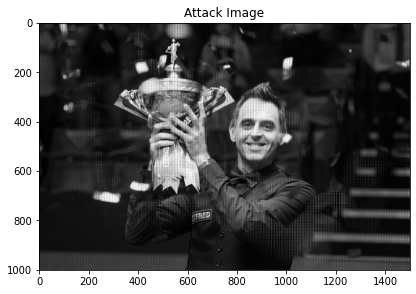

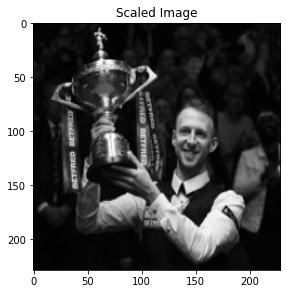

In [ ]:
# Run Strong Attack Form

# Get source and target images
src = cv2.imread(ronnie, 0)
tgt = cv2.imread(judd, 0)
a,b = tgt.shape

# Generate attack image
atk_img = StrongAttackFormGray(resizeCV2, src, tgt)

# Display attack image and output image (scaled attack image)
plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
plt.title('Attack Image')
plt.imshow(atk_img,cmap='gray', vmin=0, vmax=255)

plt.figure(figsize=(20,10))
plt.subplot(2, 2, 2)
plt.title('Scaled Image')
plt.imshow(resizeCV2(atk_img, a, b), cmap='gray', vmin=0, vmax=255)

# # Save attack image locally (change file name and don't forget to download)
# plt.imsave('{attack image name here}.jpg', atk_img, cmap='gray')
# plt.imsave('atk_ronnie.jpg', atk_img, cmap='gray')

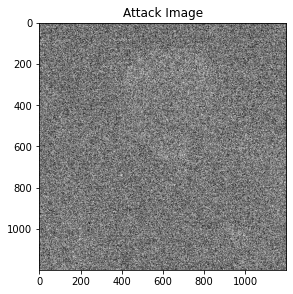

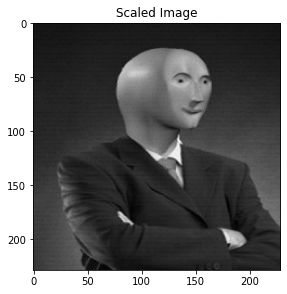

In [ ]:
# Run Weak Attack Form

# Get target image
tgt = cv2.imread(stonks, 0)
a, b = tgt.shape

# Generate attack image
atk_img = WeakAttackFormGray(resizeCV2, 1200, 1200, tgt)

# Display attack image and output image (scaled attack image)
plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
plt.title('Attack Image')
plt.imshow(atk_img,cmap='gray', vmin=0, vmax=255)

plt.figure(figsize=(20,10))
plt.subplot(2, 2, 2)
plt.title('Scaled Image')
plt.imshow(resizeCV2(atk_img, a, b), cmap='gray', vmin=0, vmax=255)

# # Save attack image locally (change file name and don't forget to download)
# plt.imsave('{attack image name here}.jpg', atk_img, cmap='gray')
plt.imsave('weak_atk_stonks.jpg', atk_img, cmap='gray')

In [ ]:
plt.imsave('weak_atk_judd.jpg', atk_img, cmap='gray')

In [ ]:
# Test existing attack image

atk_img = atk_cat
atk_img = cv2.imread(atk_img, 0)
a, b, = cv2.imread(dog_a, 0).shape
# dimensions to be scaled to
# a = 250
# b = 203
print(a)
print(b)
# Display attack image and output image (scaled attack image)
plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
plt.title('Attack Image')
plt.imshow(atk_img,cmap='gray', vmin=0, vmax=255)

plt.figure(figsize=(20,10))
plt.subplot(2, 2, 2)
plt.title('Scaled Image')
plt.imshow(resizeCV2(atk_img, a, b), cmap='gray', vmin=0, vmax=255)

## Defenses - Padding

A possible way to preemptively defend against an attack like this is to pad the input (potential attack) images prior to scaling, then cropping after scaling. This is shown below.

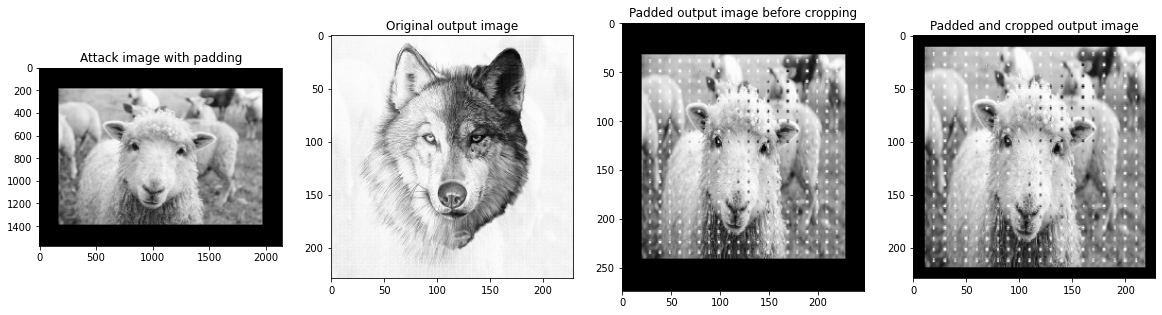

In [106]:
'''
  Input: CV2 img, optional: seed (random seed), custom dimensions for the image to be scaled to
  Output: padded attack image, resized image before cropping, cropped image
'''

def padAttackImage(img, seed, out_x=229, out_y=229):
  
  is_PIL = False
  # cv2 or Pillow Image
  # N.B. Pillow images work, but the final cropping is buggy
  try:
    # cv2 grayscale
    y, x = img.shape
  except ValueError:
    # account for colour images
    # cv2 RGB
    y, x, _ = img.shape
  except AttributeError:
    # Pillow Image
    y, x = img.size
    img = np.array(img)
    is_PIL = True

  if(seed):
    random.seed(seed)
  
  # Padding for output image
  # actual padding varies, generally each side is 10 or 11
  # this is due to multiple floor division operations and integer rounding
  # output is always out_x, out_y (default is 229, 229)
  padding = 10
  min_y = int(((y*out_y)/(out_y - padding*2) - y)/2)
  min_x = int(((x*out_x)/(out_x - padding*2) - x)/2)

  # randomly generate padding amounts for the attack image
  y_pad = random.randint(min_y, min_y*2)*2
  x_pad = random.randint(min_x, min_x*2)*2

  # pad top & bottom and left & right by the same amount
  t_atk = y_pad
  b_atk = y_pad
  l_atk = x_pad
  r_atk = x_pad

  # Padded dimensions of the attack image
  new_y = y + t_atk + b_atk
  new_x = x + l_atk + r_atk

  # scaled_y/y is the ratio of scaling of y-dimension of the original, unpadded attack image
  # and the y-dimension of the non-padded output image
  scaled_y = out_y - padding*2
  scaled_x = out_x - padding*2
  
  # initial, uncropped output dimensions (with extra padding to be cropped)
  temp_out_y = int(new_y * scaled_y/y)
  temp_out_x = int(new_x * scaled_x/x)

  # amount of padding that should be cropped
  y_pad_diff = int((temp_out_y - out_y)/2)
  x_pad_diff = int((temp_out_x - out_x)/2)
  y_correction = 0
  x_correction = 0

  # correction amounts for each dimension, accounting for floor division and integer rounding
  if(temp_out_y - y_pad_diff*2 - out_y!= 0):
    y_correction = temp_out_y - y_pad_diff*2 - out_y

  if(temp_out_x - x_pad_diff*2 - out_x!= 0):
    x_correction = temp_out_x - x_pad_diff*2 - out_x

  # add padding to the attack image
  padded = cv2.copyMakeBorder(img, t_atk, b_atk, l_atk, r_atk, cv2.BORDER_CONSTANT)
  
  # resize to the temp_out_y, temp_out_x
  resized = resizeCV2(padded, temp_out_y, temp_out_x)

  # crop to size
  cropped = resized[(y_pad_diff):(-(y_pad_diff + y_correction)), (x_pad_diff):(-(x_pad_diff + x_correction))]

  # this does not work too well with PIL
  if(is_PIL):
    padded = Image.fromarray(padded)
    resized = Image.fromarray(resized)
    cropped = Image.fromarray(cropped)

  return padded, cropped, resized

img = cv2.imread(atksheep,0)
padded, cropped, resized = padAttackImage(img, None)

ori_resize = resizeCV2(img, 229, 229)
fig, ax = plt.subplots(1,4, figsize=(20,10))
ax[3].imshow(cropped, cmap='gray')
ax[3].set_title("Padded and cropped output image")
ax[2].imshow(resized, cmap='gray')
ax[2].set_title("Padded output image before cropping")
ax[1].imshow(ori_resize, cmap='gray')
ax[1].set_title("Original output image")
ax[0].imshow(padded, cmap='gray')
ax[0].set_title("Attack image with padding")
plt.imsave('atk.jpg', cropped, cmap='gray')

#References


https://stackoverflow.com/questions/63519965/torch-transform-resize-vs-cv2-resize
https://pytorch.org/docs/stable/generated/torch.transpose.html
https://stackoverflow.com/questions/29241056/how-does-numpy-newaxis-work-and-when-to-use-it
https://docs.opencv.org/master/d3/df2/tutorial_py_basic_ops.html
https://www.cvxpy.org/tutorial/intro/index.html
https://github.com/cvxgrp/dccp
https://web.stanford.edu/~boyd/papers/pdf/dccp.pdf
https://docs.opencv.org/3.4/d8/d6a/group__imgcodecs__flags.html
https://arxiv.org/pdf/1604.02639.pdf
